In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/classification_of_reviews/all_reviews.csv"

data = pd.read_csv(file_path)

Mounted at /content/drive


In [5]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [10]:
data = data.dropna()

In [11]:
data

,Name,Description,Review,Rating,Sentiment
0,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Отличные кроссовки, очень лёгкие, на ножке акк...",10,1
1,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Красивые, стильные, удобные.",10,1
2,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Все хорошо. Идет в размер,10,1
3,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,"Удобные и красивые, но вся грязь собирается на...",8,1
4,Кроссовки NIKE AIR MAX SC,Кроссовки выполнены из натуральной кожи с текс...,Удобные пока не носоли.,10,1
...,...,...,...,...,...
486909,Женщина без правил,"Люсиль мечтает о карьере телезвезды, но из дал...","Столько эмоций! Это фильм, от которого невозмо...",10,1
486914,Новый протокол,Однажды утром лесник Рауль Крафт узнает о смер...,Réaliste \n,10,1
486915,Doraemon: Nobita's the Legend of the Sun King,Doraemon and its friends open a hole in the ti...,jodete ledinapoporu te quiero \n,8,1
486916,Doraemon: Nobita's the Legend of the Sun King,Doraemon and its friends open a hole in the ti...,Todas las peliculas de doraemon son buenas lo ...,10,1


Отзыв будет считаться положительным, если его оценка неменьше 7-ми.

Для начала обучим логистическую регрессию на «грязных» данных, но сразу будем использовать tf-idf.

## 1. Logreg без очистки

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Review']],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [13]:
X_train.shape, X_test.shape

((334338, 1), (111446, 1))

In [14]:
raw_logreg = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [15]:
raw_logreg.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [16]:
pred = raw_logreg.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.40      0.52     15343
           1       0.91      0.98      0.94     96103

    accuracy                           0.90    111446
   macro avg       0.83      0.69      0.73    111446
weighted avg       0.89      0.90      0.89    111446



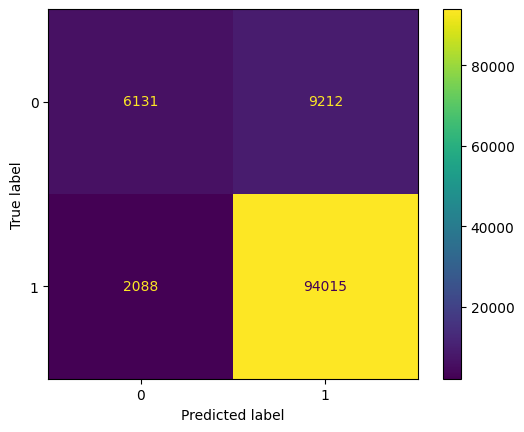

In [17]:
_ = ConfusionMatrixDisplay.from_estimator(raw_logreg, X_test['Review'], y_test)

## 2. Logreg с предобработкой (стеммер)

In [18]:
data_clean = data.copy()

In [19]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [20]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [21]:
nltk.download('punkt')
nltk.download('punkt_tab')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [22]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [24]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [25]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [26]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.72      0.45      0.55     13590
           1       0.92      0.97      0.94     85907

    accuracy                           0.90     99497
   macro avg       0.82      0.71      0.75     99497
weighted avg       0.89      0.90      0.89     99497



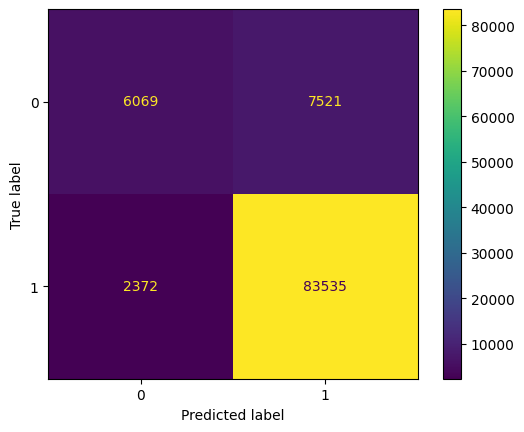

In [27]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)

In [28]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [29]:
grid_search.fit(X_train['Review'], y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [30]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [31]:
pred = best_clf.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.72      0.58      0.64     13590
           1       0.94      0.96      0.95     85907

    accuracy                           0.91     99497
   macro avg       0.83      0.77      0.80     99497
weighted avg       0.91      0.91      0.91     99497



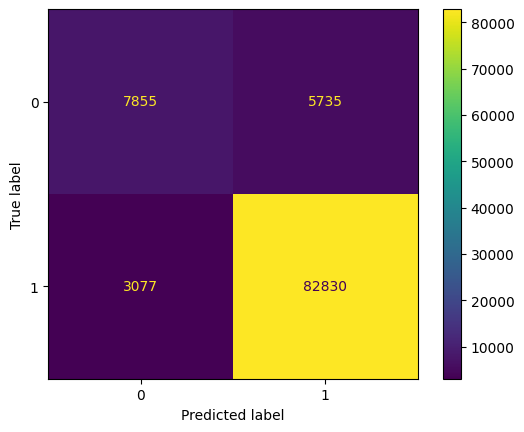

In [32]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test['Review'], y_test)

## 4. Logreg с предобработкой (стеммер + стопслова)

In [33]:
data_clean = data.copy()

In [34]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [35]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [36]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [39]:
pipeline_2 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [40]:
pipeline_2.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [41]:
pred = pipeline_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.73      0.40      0.52     13590
           1       0.91      0.98      0.94     85907

    accuracy                           0.90     99497
   macro avg       0.82      0.69      0.73     99497
weighted avg       0.89      0.90      0.89     99497



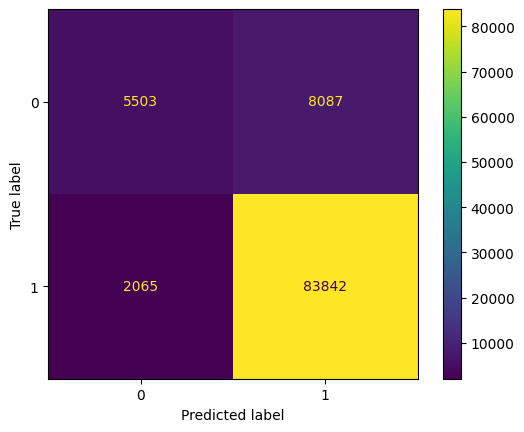

In [42]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline_2, X_test['Review'], y_test)

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)

In [43]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search_2 = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [44]:
grid_search_2.fit(X_train['Review'], y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [45]:
print("Best parameters:", grid_search_2.best_params_)
best_clf_2 = grid_search_2.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [46]:
pred = best_clf_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59     13590
           1       0.93      0.96      0.94     85907

    accuracy                           0.90     99497
   macro avg       0.81      0.74      0.77     99497
weighted avg       0.89      0.90      0.90     99497



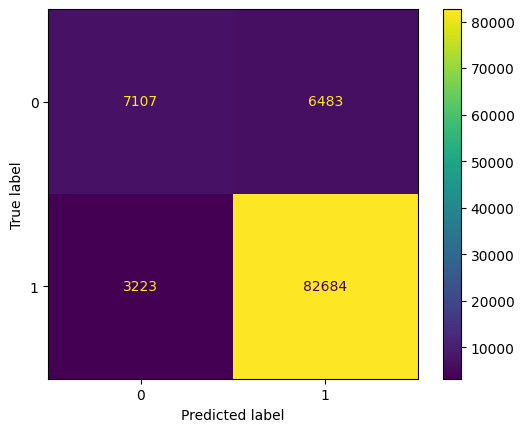

In [47]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf_2, X_test['Review'], y_test)

# Вывод

## 1. Logreg без тюнинга
Базовая модель логистической регрессии без дополнительной предобработки текста и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.75, Recall=0.40, F1=0.52
*   Класс 1 (позитивные): Precision=0.91, Recall=0.98, F1=0.94
*   Accuracy: 0.90

Модель показывает хорошие результаты для позитивных отзывов, но слабый recall для негативных (0.40), что указывает на проблему с определением негативных отзывов.

## 2. Logreg с предобработкой (стеммер)
Добавлена предобработка текста с использованием стемминга.
### Результаты:
*   Класс 0 (негативные): Precision=0.72 (-0.03), Recall=0.45 (+0.05), F1=0.55 (+0.03)
*   Класс 1 (позитивные): Precision=0.92 (+0.01), Recall=0.97 (-0.01), F1=0.94 (=)
*   Accuracy: 0.90

Стемминг немного улучшил recall для негативных отзывов (+5%), но снизил precision (-3%). Общая точность осталась прежней.

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)
Добавлен подбор гиперпараметров для модели и TF-IDF.
### Результаты:
*   Класс 0 (негативные): Precision=0.72 (=), Recall=0.58 (+0.13), F1=0.64 (+0.09)
*   Класс 1 (позитивные): Precision=0.94 (+0.02), Recall=0.96 (-0.01), F1=0.95 (+0.01)
*   Accuracy: 0.91 (+0.01)

Подбор параметров значительно улучшил recall для негативных отзывов (+13%) и общий F1-score (+0.09), что подтверждает важность настройки гиперпараметров.

## 4. Logreg с предобработкой (стеммер + стопслова)
Добавлено удаление стоп-слов к предобработке.
### Результаты:
*   Класс 0 (негативные): Precision=0.73 (+0.01), Recall=0.40 (-0.05), F1=0.52 (-0.03)
*   Класс 1 (позитивные): Precision=0.91 (-0.01), Recall=0.98 (+0.01), F1=0.94 (=)
*   Accuracy: 0.90 (-0.01)

Подбор параметров значительно улучшил recall для негативных отзывов (+13%) и общий F1-score (+0.09), что подтверждает важность настройки гиперпараметров.

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)
Комбинация стемминга, удаления стоп-слов и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.69 (-0.03), Recall=0.52 (+0.12), F1=0.59 (+0.07)
*   Класс 1 (позитивные): Precision=0.93 (+0.02), Recall=0.96 (-0.01), F1=0.94 (=)
*   Accuracy: 0.90 (=)

Несмотря на подбор параметров, удаление стоп-слов не показало преимуществ перед чистым стеммингом с настройкой (эксперимент 3).

## Итог
### Лучшая конфигурация
Эксперимент 3 (стемминг + подбор гиперпараметров) показал наилучшие результаты:
*   Максимальный F1-score для негативных отзывов (0.64)
*   Высокий баланс между precision и recall для обоих классов
*   Незначительное улучшение общей accuracy (0.91)

### Ключевые наблюдения:
1. Стемминг дает небольшое улучшение качества
2. Подбор гиперпараметров оказывает наиболее значимое положительное влияние
3. Удаление стоп-слов в данном случае не улучшает модель
